# Topic 2 – Frequency Representations (FFT and Spectrogram)

*DSP for Audio – Offline Notebook*

**Dataset folder:** `../audio_dataset/`


Offline lab: FFT + spectrogram using SciPy.


## Setup


In [4]:
import os

REPO_URL = "https://github.com/fabioantonacci79/BasicDSP.git"
REPO_NAME = "BasicDSP"

if not os.path.exists(REPO_NAME):
    !git clone {REPO_URL}

%cd BasicDSP/notebooks


import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from pathlib import Path
from IPython.display import Audio, display
import ipywidgets as widgets


DATA_DIR = Path('audio_dataset')
SR_DEFAULT = 16000

def load_wav(path):
    sr, x = wavfile.read(path)
    # Convert to float in [-1, 1]
    if x.dtype == np.int16:
        x = x.astype(np.float32) / 32768.0
    elif x.dtype == np.int32:
        x = x.astype(np.float32) / 2147483648.0
    else:
        x = x.astype(np.float32)
    if x.ndim > 1:
        x = x.mean(axis=1)  # mono
    return sr, x

def save_wav(path, sr, x):
    x = np.asarray(x, dtype=np.float32)
    x = np.clip(x, -1, 1)
    wavfile.write(path, sr, (x * 32767).astype(np.int16))

def play(x, sr):
    display(Audio(x, rate=sr))

def plot_time(x, sr, title='Time signal', seconds=0.05):
    n = min(len(x), int(seconds*sr))
    tt = np.arange(n)/sr
    plt.figure()
    plt.plot(tt, x[:n])
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_spectrum(x, sr, title='Magnitude spectrum'):
    N = len(x)
    w = np.hanning(N)
    X = np.fft.rfft(x*w)
    f = np.fft.rfftfreq(N, d=1/sr)
    mag = 20*np.log10(np.abs(X)+1e-12)
    plt.figure()
    plt.plot(f, mag)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.title(title)
    plt.grid(True)
    plt.xlim(0, sr/2)
    plt.show()


Cloning into 'BasicDSP'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 176 (delta 95), reused 120 (delta 51), pack-reused 0 (from 0)
Receiving objects: 100% (176/176), 14.18 MiB | 2.55 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/Users/fabioantonacci/Documents/GitHub/BasicDSP/notebooks/BasicDSP/notebooks/BasicDSP/notebooks


## 2.1 DFT Spectral leakage

In [4]:
# --- Fixed signal settings (keep simple; you can expose these as sliders later if you want) ---
fs = 10.0       # sampling frequency [Hz]
f0 = 1.0         # sinusoid frequency [Hz] (chosen so coherence depends on N)
A  = 1.0          # amplitude

def make_window(win_type, N):
    if win_type == "Rectangular":
        return np.ones(N)
    elif win_type == "Hamming":
        return np.hamming(N)
    else:
        raise ValueError("Unknown window type")

def leakage_demo(N, win_type, pad_factor, show_time):
    N = int(N)
    t = np.arange(N) / fs
    x = A * np.sin(2*np.pi*f0*t)

    w = make_window(win_type, N)
    xw = x * w

    # Zero-padding helps make the leakage pattern easier to see (interpolated spectrum)
    nfft = int(2**np.ceil(np.log2(N * pad_factor)))
    X = np.fft.rfft(xw, n=nfft)
    f = np.fft.rfftfreq(nfft, d=1/fs)

    mag = np.abs(X)
    mag_db = 20*np.log10(mag / (mag.max() + 1e-12) + 1e-12)

    # Useful indicator: how many periods are inside the window?
    periods_in_window = f0 * (N / fs)

    plt.close("all")
    if show_time:
        fig, ax = plt.subplots(2, 1, figsize=(9, 6), constrained_layout=True)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(9, 4), constrained_layout=True)
        ax = [ax]

    # (Optional) time-domain view
    if show_time:
        ax[0].plot(t, x, label="x[n] (sinusoid)")
        ax[0].plot(t, xw, label=f"x[n]·w[n] ({win_type})")
        ax[0].set_title(f"Windowed sinusoid | N={N} samples | periods in window ≈ {periods_in_window:.3f}")
        ax[0].set_xlabel("Time [s]")
        ax[0].set_ylabel("Amplitude")
        ax[0].grid(True, which="both", linestyle="--", linewidth=0.5)
        ax[0].legend(loc="upper right")

        spec_ax = ax[1]
    else:
        spec_ax = ax[0]
        spec_ax.set_title(f"Spectrum | N={N} | {win_type} | periods in window ≈ {periods_in_window:.3f}")

    # Spectrum
    spec_ax.plot(f, mag_db)
    spec_ax.set_xlim(0, min(fs/2, 200))  # focus on low frequencies; adjust as desired
    spec_ax.set_ylim(-120, 5)
    spec_ax.set_xlabel("Frequency [Hz]")
    spec_ax.set_ylabel("Magnitude [dB] (normalized)")
    spec_ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Mark the sinusoid frequency for reference
    spec_ax.axvline(f0, linestyle="--", linewidth=1)
    plt.show()

# --- Widgets requested: window length + window type ---
N_slider = widgets.IntSlider(
    value=256, min=32, max=4096, step=1,
    description="N (window)", continuous_update=False
)

win_dropdown = widgets.Dropdown(
    options=["Rectangular", "Hamming"],
    value="Rectangular",
    description="Window"
)

pad_slider = widgets.IntSlider(
    value=8, min=0, max=32, step=1,
    description="Zero-pad×", continuous_update=False
)

show_time_checkbox = widgets.Checkbox(
    value=True, description="Show time-domain"
)

ui = widgets.HBox([N_slider, win_dropdown, pad_slider, show_time_checkbox])
out = widgets.interactive_output(
    leakage_demo,
    {"N": N_slider, "win_type": win_dropdown, "pad_factor": pad_slider, "show_time": show_time_checkbox}
)

display(ui, out)


Output()

## 2.2 Effect of the spectral leakage on the frequency resolution

In [5]:
# Fixed settings
fs = 100.0      # [Hz]
f1 = 10.0        # fixed sinusoid frequency [Hz]
A1 = 1.0
A2 = 0.8         # slightly smaller so masking is visible

def make_window(win_type, N):
    if win_type == "Rectangular":
        return np.ones(N)
    elif win_type == "Hamming":
        return np.hamming(N)
    else:
        raise ValueError("Unknown window type")

def two_tone_leakage_demo(N, win_type, f2, pad_factor, show_time):
    N = int(N)
    f2 = float(f2)

    t = np.arange(N) / fs
    x1 = A1 * np.sin(2*np.pi*f1*t)
    x2 = A2 * np.sin(2*np.pi*f2*t)
    x  = x1 + x2

    w = make_window(win_type, N)
    xw = x * w

    # zero-padding for smoother-looking spectrum
    nfft = int(2**np.ceil(np.log2(N * pad_factor)))
    X = np.fft.rfft(xw, n=nfft)
    f = np.fft.rfftfreq(nfft, d=1/fs)

    mag = np.abs(X)
    mag_db = 20*np.log10(mag / (mag.max() + 1e-12) + 1e-12)

    # handy metrics for the title
    df_bin = fs / N                 # DFT bin spacing (true resolution scale)
    T = N / fs                      # window length in seconds

    plt.close("all")
    if show_time:
        fig, ax = plt.subplots(2, 1, figsize=(9, 6), constrained_layout=True)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(9, 4), constrained_layout=True)
        ax = [ax]

    if show_time:
        ax[0].plot(t, x, label="x[n] = x1 + x2")
        ax[0].plot(t, xw, label=f"x[n]·w[n] ({win_type})")
        ax[0].set_title(f"Two-tone signal | N={N} | T={T:.3f}s | Δf(bin)=fs/N={df_bin:.3f} Hz")
        ax[0].set_xlabel("Time [s]")
        ax[0].set_ylabel("Amplitude")
        ax[0].grid(True, which="both", linestyle="--", linewidth=0.5)
        ax[0].legend(loc="upper right")
        spec_ax = ax[1]
    else:
        spec_ax = ax[0]
        spec_ax.set_title(f"Spectrum | N={N} | {win_type} | Δf(bin)={df_bin:.3f} Hz")

    # Spectrum plot (focus around the tones)
    fmax = max(80, f2 + 40)
    spec_ax.plot(f, mag_db)
    spec_ax.set_xlim(0, min(fs/2, fmax))
    spec_ax.set_ylim(-120, 5)
    spec_ax.set_xlabel("Frequency [Hz]")
    spec_ax.set_ylabel("Magnitude [dB] (normalized)")
    spec_ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Mark tones
    spec_ax.axvline(f1, linestyle="--", linewidth=1)
    spec_ax.axvline(f2, linestyle="--", linewidth=1)

    # Text annotation: frequency separation vs bin spacing
    sep = abs(f2 - f1)
    spec_ax.text(
        0.02, 0.08,
        f"f1={f1:.1f} Hz (fixed)\n"
        f"f2={f2:.1f} Hz (slider)\n"
        f"|f2-f1|={sep:.2f} Hz\n"
        f"bin spacing fs/N={df_bin:.2f} Hz",
        transform=spec_ax.transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round", alpha=0.1)
    )

    plt.show()

# Widgets
N_slider = widgets.IntSlider(
    value=512, min=32, max=4096, step=1,
    description="N (window)", continuous_update=False
)
win_dropdown = widgets.Dropdown(
    options=["Rectangular", "Hamming"],
    value="Rectangular",
    description="Window"
)
f2_slider = widgets.FloatSlider(
    value=14.0, min=1.0, max=60.0, step=0.1,
    description="f2 [Hz]", continuous_update=False
)
pad_slider = widgets.IntSlider(
    value=8, min=1, max=32, step=1,
    description="Zero-pad×", continuous_update=False
)
show_time_checkbox = widgets.Checkbox(
    value=False, description="Show time-domain"
)

ui = widgets.VBox([
    widgets.HBox([N_slider, win_dropdown]),
    widgets.HBox([f2_slider, pad_slider, show_time_checkbox])
])

out = widgets.interactive_output(
    two_tone_leakage_demo,
    {"N": N_slider, "win_type": win_dropdown, "f2": f2_slider,
     "pad_factor": pad_slider, "show_time": show_time_checkbox}
)

display(ui, out)


Output()

## 2.3 FFT on audio

Compute spectra of dataset signals.


sr 16000 duration 6.0


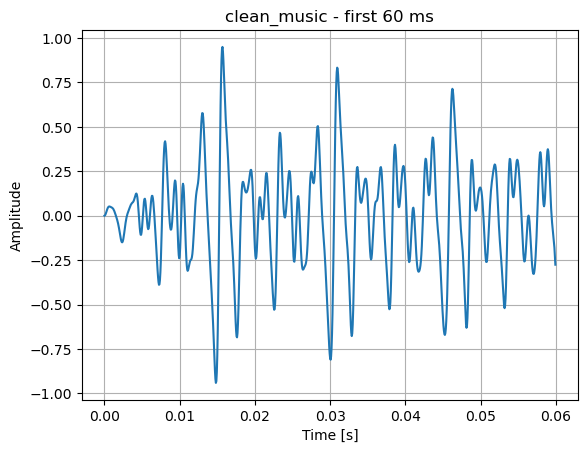

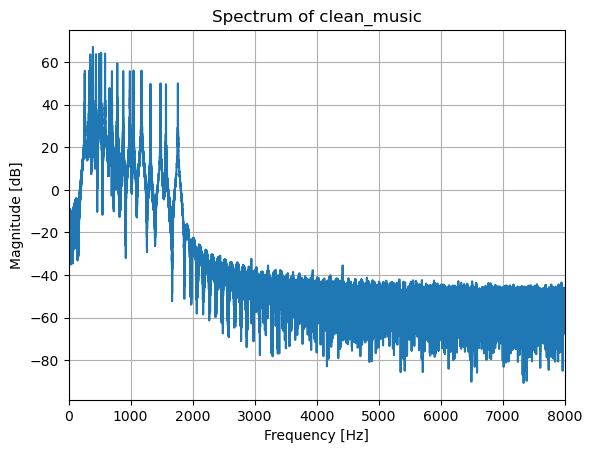

In [8]:
sr, x = load_wav(DATA_DIR/'clean_music.wav')
print('sr', sr, 'duration', len(x)/sr)
plot_time(x, sr, title='clean_music - first 60 ms', seconds=0.06)
play(x, sr)
plot_spectrum(x, sr, title='Spectrum of clean_music')


### Task A (TODO)
Try the spectrum of:
- `clean_music.wav`
- `clean_percussive.wav`

Which one is more harmonic?



File: clean_music.wav


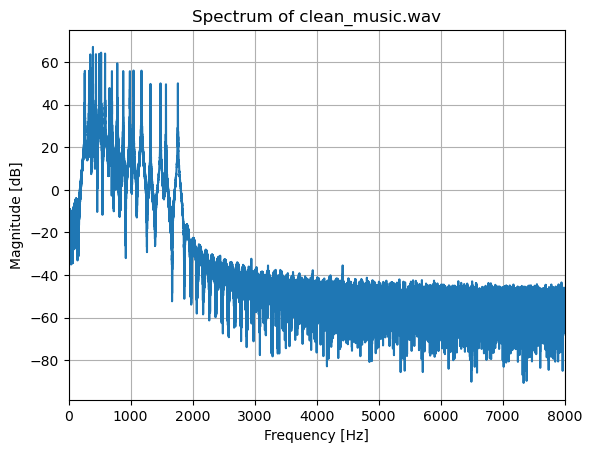


File: clean_speechlike.wav


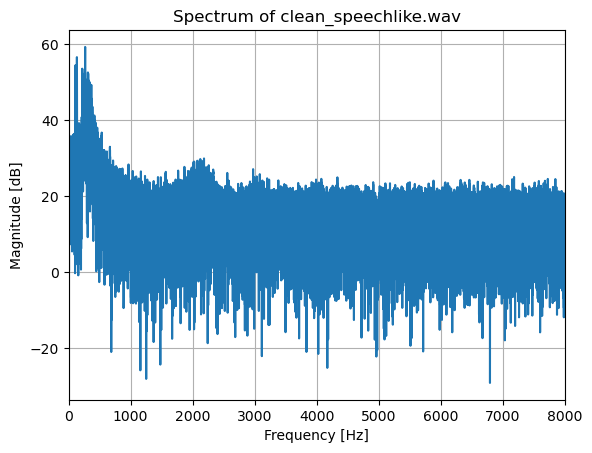

In [13]:
for fname in ['clean_music.wav', 'clean_speechlike.wav']:
    sr, x = load_wav(DATA_DIR/fname)
    print('\nFile:', fname)
    play(x, sr)
    plot_spectrum(x, sr, title=f'Spectrum of {fname}')


## 2.4 Spectrogram

A spectrogram shows how frequency content changes over time.


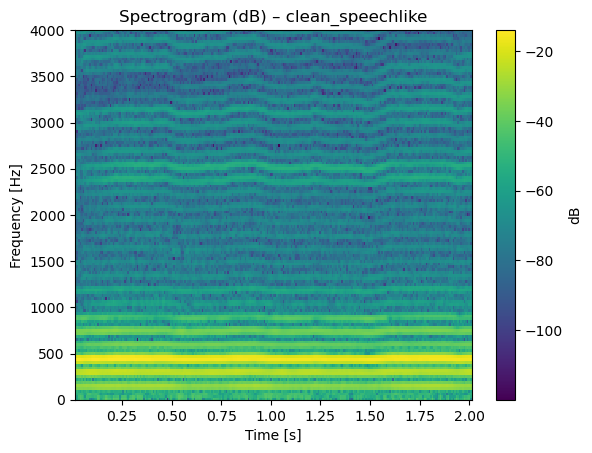

In [15]:
sr, x = load_wav(DATA_DIR/'O.wav')
f, tt, Sxx = signal.spectrogram(x, fs=sr, window='hann', nperseg=512, noverlap=384, scaling='spectrum')
S_db = 10*np.log10(Sxx + 1e-12)
plt.figure()
plt.pcolormesh(tt, f, S_db, shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram (dB) – clean_speechlike')
plt.ylim(0, 4000)
plt.colorbar(label='dB')
plt.show()


### Task B (TODO)
Compare spectrograms of:
- `clean_music.wav`
- `clean_percussive.wav`
- `speechlike_with_50hz_hum.wav`

Can you spot a 50 Hz horizontal line?


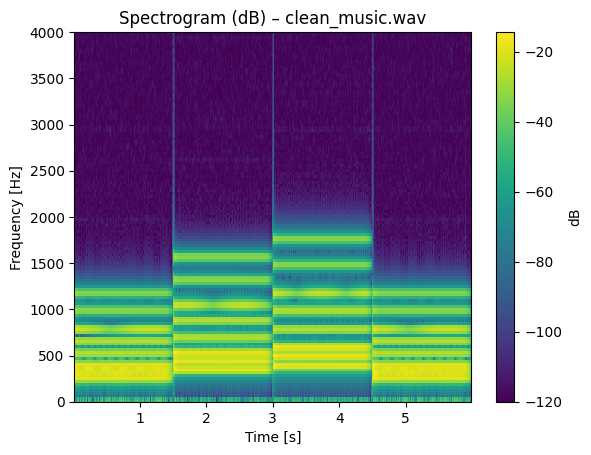

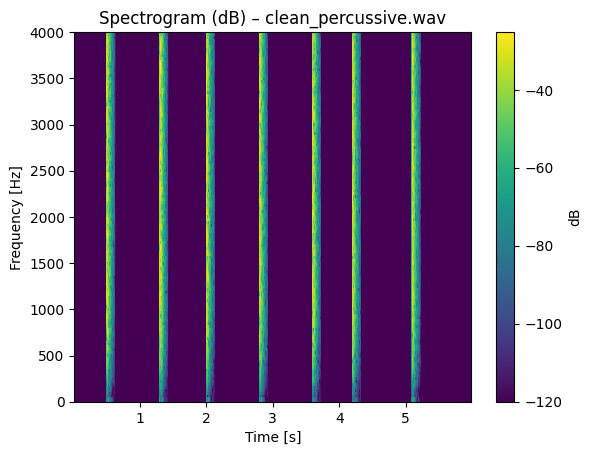

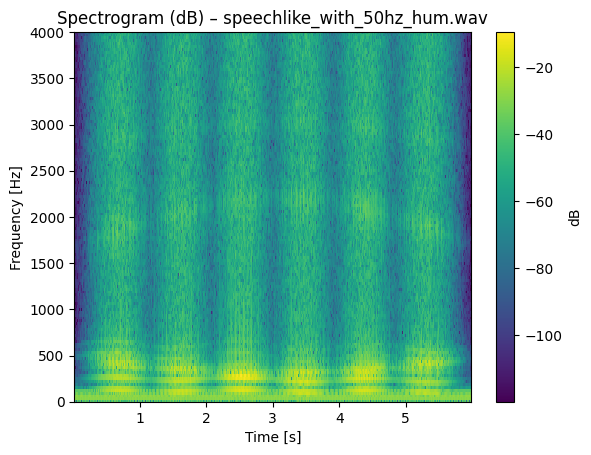

In [10]:
for fname in ['clean_music.wav', 'clean_percussive.wav', 'speechlike_with_50hz_hum.wav']:
    sr, x = load_wav(DATA_DIR/fname)
    f, tt, Sxx = signal.spectrogram(x, fs=sr, window='hann', nperseg=512, noverlap=384, scaling='spectrum')
    S_db = 10*np.log10(Sxx + 1e-12)
    plt.figure()
    plt.pcolormesh(tt, f, S_db, shading='auto')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(f'Spectrogram (dB) – {fname}')
    plt.ylim(0, 4000)
    plt.colorbar(label='dB')
    plt.show()



## Demonstrating frequency aliasing in the spectrogram

Old sampling factor: 16000  New sampling factor: 8000


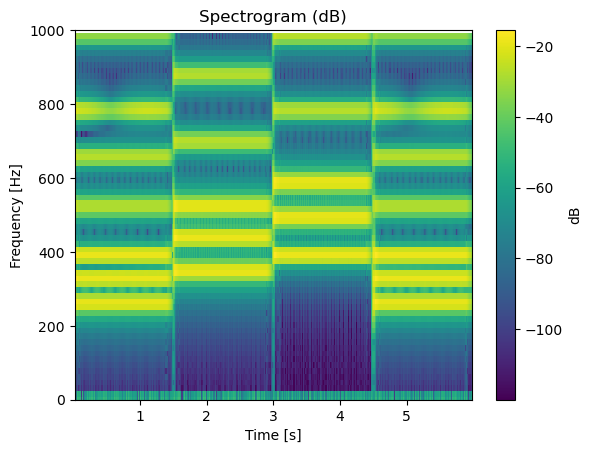

Old sampling factor: 16000  New sampling factor: 4000


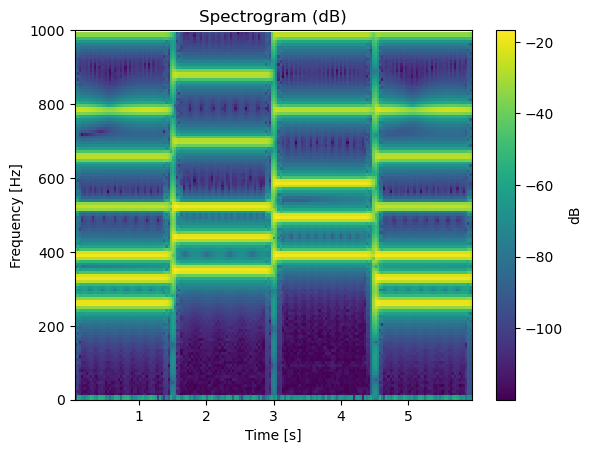

Old sampling factor: 16000  New sampling factor: 2000


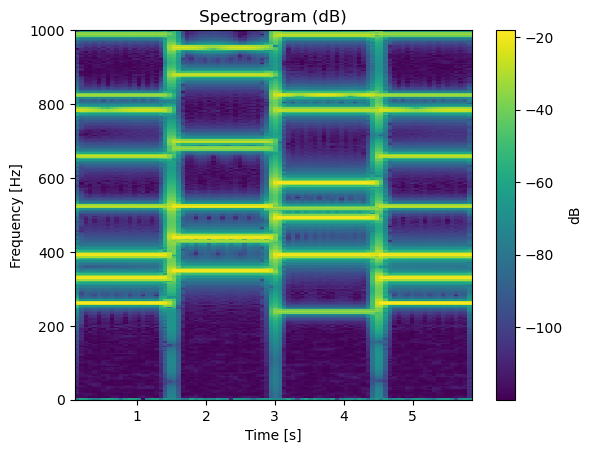

In [17]:
def decimate_simple(x, sr_old, sr_new):
    k = int(sr_old // sr_new)
    return x[::k]
sr, x = load_wav(DATA_DIR/'clean_music.wav')

for sr_new in [8000, 4000, 2000]:
    dec_factor = sr/sr_new
    x_new = decimate_simple(x, sr, sr_new)
    print("Old sampling factor:", sr, " New sampling factor:", sr_new)
    f, tt, Sxx = signal.spectrogram(x_new, fs=sr_new, window='hann', nperseg=512, noverlap=384, scaling='spectrum')
    S_db = 10*np.log10(Sxx + 1e-12)
    plt.figure()
   # print("size:",np.size(S_db),np.size(S_db[1]),len(f))
    plt.pcolormesh(tt, f[0:int(2000/sr_new*257)], S_db[0:int(2000/sr_new*257),:], shading='auto')

    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(f'Spectrogram (dB)')
    plt.ylim(0, 1000)
    plt.colorbar(label='dB')
    plt.show()
